# Markov Chain basics
Andrey Markov was a Russian mathematician who studied stochastic processes. Markov was particularly interested in systems that follow a chain of linked events. In 1906, Markov produced interesting results about discrete processes that he called chain. A **Markov Chain** has a set of states S={s0,s1,...,sm} and a process that can move successively from one state to another. Each move is a single step and is based on a transition model T

To summarise a Markov chain is defined by:

$\bf{Set\ of\ possible\ States:}S=\{{s_0,s_1,...,s_m}\}$

$\bf{Initial\ State}: s_0$

$\bf{Transition\ Model}: T(s,s^′)$

A Markov chain is based on the Markov Property. The Markov property states that **given the present, the future is conditionally independent of the past.**

Let’s suppose we have a chain with only two states $s_0$ and $s_1$, where $s_0$ is the initial state. The process is in $s_0$ 90% of the time and it can move to $s_1$ the remaining 10% of the time. When the process is in state $s_1$ it will remain there 50% of the time.

So, the transition matrix can be written as,

$$T=\quad
\begin{bmatrix}
0.9 & 0.1 \\
0.5 & 0.5
\end{bmatrix}$$

The transition matrix is always a square matrix, and since we are dealing with probability distributions all the entries are within 0 and 1 and a single row sums to 1.

Here is the state diagram,

![MDP-1](https://mpatacchiola.github.io/blog/images/simple_markov_chain.png)

In [1]:
%%html
<style>
body {
    font-family: "Comic Sans MS", cursive, sans-serif;
}
</style> 

In [223]:
import random, time
import numpy as np
from collections import defaultdict
import operator
import matplotlib.pyplot as plt
import pandas as pd
from seaborn import heatmap

## Misc functions and utilities

In [2]:
orientations = EAST, NORTH, WEST, SOUTH = [(1, 0), (0, 1), (-1, 0), (0, -1)]
turns = LEFT, RIGHT = (+1, -1)

In [3]:
def vector_add(a, b):
    """Component-wise addition of two vectors."""
    return tuple(map(operator.add, a, b))

In [4]:
def turn_heading(heading, inc, headings=orientations):
    return headings[(headings.index(heading) + inc) % len(headings)]


def turn_right(heading):
    return turn_heading(heading, RIGHT)

def turn_left(heading):
    return turn_heading(heading, LEFT)

def distance(a, b):
    """The distance between two (x, y) points."""
    xA, yA = a
    xB, yB = b
    return math.hypot((xA - xB), (yA - yB))

In [5]:
def isnumber(x):
    """Is x a number?"""
    return hasattr(x, '__int__')

### Function to generate grid data (list of lists) with arbitrary size and complexity for the grid world

In [6]:
def gen_mdp(nrows=3,ncols=4,terminals = [(3,2),(3,1)],main_reward = -0.04,
            terminal_rewards = [1,-1],block_coords = [(1,1)]):
    """
    Generates a list of list to feed to the main GridMDP class from simple user API
    nrows: Number of rows
    ncols: Number of columns
    terminals: Coordinates of terminal points, list of tuples
    main_reward: The default reward for traversing the grid world
    block_coords: Coordinates of solid blocks, list of tules
    """
    
    x = [[main_reward] * ncols for i in range(nrows)]
    for i,t in enumerate(terminals):
        x[t[1]][t[0]]=terminal_rewards[i]
    for b in block_coords:
        x[b[1]][b[0]]=None
    x.reverse()
       
    return x

## Class definitions

### Base MDP class

In [7]:
class MDP:
    """A Markov Decision Process, defined by an initial state, transition model,
    and reward function. We also keep track of a gamma value, for use by
    algorithms. The transition model is represented somewhat differently from
    the text. Instead of P(s' | s, a) being a probability number for each
    state/state/action triplet, we instead have T(s, a) return a
    list of (p, s') pairs. We also keep track of the possible states,
    terminal states, and actions for each state."""

    def __init__(self, init, actlist, terminals, transitions = {}, reward = None, states=None, gamma=.9):
        if not (0 < gamma <= 1):
            raise ValueError("An MDP must have 0 < gamma <= 1")

        if states:
            self.states = states
        else:
            ## collect states from transitions table
            self.states = self.get_states_from_transitions(transitions)
            
        
        self.init = init
        
        if isinstance(actlist, list):
            ## if actlist is a list, all states have the same actions
            self.actlist = actlist
        elif isinstance(actlist, dict):
            ## if actlist is a dict, different actions for each state
            self.actlist = actlist
        
        self.terminals = terminals
        self.transitions = transitions
        if self.transitions == {}:
            print("Warning: Transition table is empty.")
        self.gamma = gamma
        if reward:
            self.reward = reward
        else:
            self.reward = {s : 0 for s in self.states}
        #self.check_consistency()

    def R(self, state):
        """Return a numeric reward for this state."""
        return self.reward[state]

    def T(self, state, action):
        """Transition model. From a state and an action, return a list
        of (probability, result-state) pairs."""
        if(self.transitions == {}):
            raise ValueError("Transition model is missing")
        else:
            return self.transitions[state][action]

    def actions(self, state):
        """Set of actions that can be performed in this state. By default, a
        fixed list of actions, except for terminal states. Override this
        method if you need to specialize by state."""
        if state in self.terminals:
            return [None]
        else:
            return self.actlist

    def get_states_from_transitions(self, transitions):
        if isinstance(transitions, dict):
            s1 = set(transitions.keys())
            s2 = set([tr[1] for actions in transitions.values() 
                              for effects in actions.values() for tr in effects])
            return s1.union(s2)
        else:
            print('Could not retrieve states from transitions')
            return None

    def check_consistency(self):
        # check that all states in transitions are valid
        assert set(self.states) == self.get_states_from_transitions(self.transitions)
        # check that init is a valid state
        assert self.init in self.states
        # check reward for each state
        #assert set(self.reward.keys()) == set(self.states)
        assert set(self.reward.keys()) == set(self.states)
        # check that all terminals are valid states
        assert all([t in self.states for t in self.terminals])
        # check that probability distributions for all actions sum to 1
        for s1, actions in self.transitions.items():
            for a in actions.keys():
                s = 0
                for o in actions[a]:
                    s += o[0]
                assert abs(s - 1) < 0.001

### Transition matrix, init, termianls, rewards

In [8]:
# Transition Matrix as nested dict. State -> Actions in state -> List of (Probability, State) tuples
t = {
    "A": {
            "X": [(0.3, "A"), (0.7, "B")],
            "Y": [(1.0, "A")]
         },
    "B": {
            "X": {(0.8, "End"), (0.2, "B")},
            "Y": {(1.0, "A")}
         },
    "End": {}
}

init = "A"

terminals = ["End"]

rewards = {
    "A": 5,
    "B": -10,
    "End": 100
}

### Custom MDP subclass

In [9]:
class CustomMDP(MDP):
    def __init__(self, init, terminals, transition_matrix, reward = None, gamma=.9):
        # All possible actions.
        actlist = []
        for state in transition_matrix.keys():
            actlist.extend(transition_matrix[state])
        actlist = list(set(actlist))
        MDP.__init__(self, init, actlist, terminals, transition_matrix, reward, gamma=gamma)

    def T(self, state, action):
        if action is None:
            return [(0.0, state)]
        else: 
            return self.t[state][action]

In [10]:
our_mdp = CustomMDP(init, terminals, t, rewards, gamma=.9)

In [11]:
our_mdp.actions('A')

['X', 'Y']

### Grid MDP

In [12]:
class GridMDP(MDP):

    """A two-dimensional grid MDP, as in [Figure 17.1]. All you have to do is
    specify the grid as a list of lists of rewards; use None for an obstacle
    (unreachable state). Also, you should specify the terminal states.
    An action is an (x, y) unit vector; e.g. (1, 0) means move east."""

    def __init__(self, grid, terminals, init=(0, 0), gamma=.9):
        grid.reverse()  # because we want row 0 on bottom, not on top
        reward = {}
        states = set()
        self.rows = len(grid)
        self.cols = len(grid[0])
        self.grid = grid
        for x in range(self.cols):
            for y in range(self.rows):
                if grid[y][x] is not None:
                    states.add((x, y))
                    reward[(x, y)] = grid[y][x]
        self.states = states
        actlist = orientations
        transitions = {}
        for s in states:
            transitions[s] = {}
            for a in actlist:
                transitions[s][a] = self.calculate_T(s, a)
        MDP.__init__(self, init, actlist=actlist,
                     terminals=terminals, transitions = transitions, 
                     reward = reward, states = states, gamma=gamma)

    def calculate_T(self, state, action):
        if action is None:
            return [(0.0, state)]
        else:
            return [(0.8, self.go(state, action)),
                    (0.1, self.go(state, turn_right(action))),
                    (0.1, self.go(state, turn_left(action)))]
    
    def T(self, state, action):
        if action is None:
            return [(0.0, state)]
        else:
            return self.transitions[state][action]
 
    def go(self, state, direction):
        """Return the state that results from going in this direction."""
        state1 = vector_add(state, direction)
        return state1 if state1 in self.states else state

    def to_grid(self, mapping):
        """Convert a mapping from (x, y) to v into a [[..., v, ...]] grid."""
        return list(reversed([[mapping.get((x, y), None)
                               for x in range(self.cols)]
                              for y in range(self.rows)]))

    def to_arrows(self, policy):
        chars = {
            (1, 0): '→', (0, 1): '↑', (-1, 0): '←', (0, -1): '↓', None: 'TERMINAL'}
        return self.to_grid({s: chars[a] for (s, a) in policy.items()})

### Grid example

![grid-mdp](https://raw.githubusercontent.com/aimacode/aima-python/c16bb8bdc28e8f9fcc6e7f76a92b9492bf019d87/images/grid_mdp.jpg)

In [13]:
grid_rewards = [[-0.04, -0.04, -0.04, +1],
        [-0.04, None,  -0.04, -1],
        [-0.04, -0.04, -0.04, -0.04]]

In [14]:
grid_terminals = [(3, 2), (3, 1)]

In [15]:
grid_1= GridMDP(grid_rewards,grid_terminals,gamma=0.95)

In [16]:
grid_1.states

{(0, 0),
 (0, 1),
 (0, 2),
 (1, 0),
 (1, 2),
 (2, 0),
 (2, 1),
 (2, 2),
 (3, 0),
 (3, 1),
 (3, 2)}

In [17]:
grid_1.actions((1,2))

[(1, 0), (0, 1), (-1, 0), (0, -1)]

In [18]:
grid_1.actions((3,2))

[None]

In [19]:
grid_1.grid

[[-0.04, -0.04, -0.04, -0.04],
 [-0.04, None, -0.04, -1],
 [-0.04, -0.04, -0.04, 1]]

In [20]:
grid_1.T((1,2),(0,1))

[(0.8, (1, 2)), (0.1, (2, 2)), (0.1, (0, 2))]

In [21]:
grid_1.T((3,2),(0,1))

[(0.8, (3, 2)), (0.1, (3, 2)), (0.1, (2, 2))]

## Value iteration

### Value iteration function

In [22]:
def value_iteration(mdp, epsilon=0.001):
    """Solving an MDP by value iteration.
    mdp: The MDP object
    epsilon: Stopping criteria
    """
    U1 = {s: 0 for s in mdp.states}
    R, T, gamma = mdp.R, mdp.T, mdp.gamma
    iter_count=0
    while True:
        iter_count+=1
        U = U1.copy()
        delta = 0
        for s in mdp.states:
            U1[s] = R(s) + gamma * max([sum([p * U[s1] for (p, s1) in T(s, a)])
                                        for a in mdp.actions(s)])
            delta = max(delta, abs(U1[s] - U[s]))
        if delta < epsilon * (1 - gamma) / gamma:
            return (U,iter_count)

In [23]:
def value_iteration_over_time(mdp, iterations=20):
    U_over_time = []
    U1 = {s: 0 for s in mdp.states}
    R, T, gamma = mdp.R, mdp.T, mdp.gamma
    for _ in range(iterations):
        U = U1.copy()
        for s in mdp.states:
            U1[s] = R(s) + gamma * max([sum([p * U[s1] for (p, s1) in T(s, a)])
                                        for a in mdp.actions(s)])
        U_over_time.append(U)
    return U_over_time

### Plotting value updates over time/iteration

In [24]:
def plot_value_update(mdp,iterations=10):
    """
    Plot value updates over iterations for a given MDP.
    """
    x = value_iteration_over_time(mdp,iterations=iterations)
    value_states = {k:[] for k in mdp.states}
    for i in x:
        for k,v in i.items():
            value_states[k].append(v)
    plt.figure(figsize=(8,5))
    for v in value_states:
        plt.plot(value_states[v])
        plt.legend(list(value_states.keys()),fontsize=14)
    plt.grid(True)
    plt.xlabel("Iterations",fontsize=14)
    plt.ylabel("Utilities of states",fontsize=14)
    plt.show()

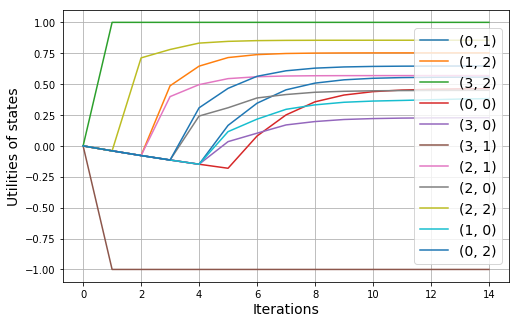

In [25]:
plot_value_update(grid_1,15)

### Determining best policy by enumerating utilities from the value iteration

In [ ]:
def best_policy(mdp, U):
    """Given an MDP and a utility function U, determine the best policy,
    as a mapping from state to action."""

    pi = {}
    for s in mdp.states:
        pi[s] = max(mdp.actions(s), key=lambda a: expected_utility(a, s, U, mdp))
    return pi

### Value iteration visualization

In [26]:
def value_iteration_instru(mdp, iterations=20):
    U_over_time = []
    U1 = {s: 0 for s in mdp.states}
    R, T, gamma = mdp.R, mdp.T, mdp.gamma
    for _ in range(iterations):
        U = U1.copy()
        for s in mdp.states:
            U1[s] = R(s) + gamma * max([sum([p * U[s1] for (p, s1) in T(s, a)])
                                        for a in mdp.actions(s)])
        U_over_time.append(U)
    return U_over_time

In [27]:
columns = 4
rows = 3
U_over_time = value_iteration_instru(grid_1)

In [28]:
def make_plot_grid_step_function(columns, rows, U_over_time):
    """ipywidgets interactive function supports single parameter as input.
    This function creates and return such a function by taking as input
    other parameters."""

    def plot_grid_step(iteration):
        data = U_over_time[iteration]
        data = defaultdict(lambda: 0, data)
        grid = []
        for row in range(rows):
            current_row = []
            for column in range(columns):
                current_row.append(data[(column, row)])
            grid.append(current_row)
        grid.reverse() # output like book
        fig = plt.figure(figsize=(rows,columns))
        fig = plt.imshow(grid, cmap=plt.cm.bwr, interpolation='nearest')

        plt.axis('off')
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

        for col in range(len(grid)):
            for row in range(len(grid[0])):
                magic = grid[col][row]
                fig.axes.text(row, col, "{0:.2f}".format(magic), va='center', ha='center')

        plt.show()

    return plot_grid_step

In [29]:
def make_visualize(slider):
    """Takes an input a sliderand returns callback function
    for timer and animation."""

    def visualize_callback(Visualize, time_step):
        if Visualize is True:
            for i in range(slider.min, slider.max + 1):
                slider.value = i
                time.sleep(float(time_step))

    return visualize_callback

In [30]:
plot_grid_step = make_plot_grid_step_function(columns, rows, U_over_time)

In [31]:
import ipywidgets as widgets
from IPython.display import display

iteration_slider = widgets.IntSlider(min=1, max=15, step=1, value=0)
w=widgets.interactive(plot_grid_step,iteration=iteration_slider)
display(w)

visualize_callback = make_visualize(iteration_slider)

visualize_button = widgets.ToggleButton(description = "Visualize", value = False)
time_select = widgets.ToggleButtons(description='Extra Delay:',options=['0', '0.1', '0.2', '0.5', '0.7', '1.0'])
a = widgets.interactive(visualize_callback, Visualize = visualize_button, time_step=time_select)
display(a)

interactive(children=(IntSlider(value=1, description='iteration', max=15, min=1), Output()), _dom_classes=('widget-interact',))

interactive(children=(ToggleButton(value=False, description='Visualize'), ToggleButtons(description='Extra Delay:', options=('0', '0.1', '0.2', '0.5', '0.7', '1.0'), value='0'), Output()), _dom_classes=('widget-interact',))

### Value iteration for a larger Grid World
Let us use the `gen_mdp` function to generate a large (10x10) and more complex grid world and run value iteration on it and visualize!

In [103]:
large_grid = gen_mdp(nrows=10,ncols=10,terminals=[(6, 3), (5, 2),(4,4)],main_reward=-0.04,
                     terminal_rewards=[1,-1,-1],block_coords=[(1,1),(2,3),(7,5),(8,2)])

In [104]:
large_gridworld = GridMDP(large_grid,terminals=[(6, 3), (5, 2),(4,4)])

In [105]:
large_gridworld.grid

[[-0.04, -0.04, -0.04, -0.04, -0.04, -0.04, -0.04, -0.04, -0.04, -0.04],
 [-0.04, None, -0.04, -0.04, -0.04, -0.04, -0.04, -0.04, -0.04, -0.04],
 [-0.04, -0.04, -0.04, -0.04, -0.04, -1, -0.04, -0.04, None, -0.04],
 [-0.04, -0.04, None, -0.04, -0.04, -0.04, 1, -0.04, -0.04, -0.04],
 [-0.04, -0.04, -0.04, -0.04, -1, -0.04, -0.04, -0.04, -0.04, -0.04],
 [-0.04, -0.04, -0.04, -0.04, -0.04, -0.04, -0.04, None, -0.04, -0.04],
 [-0.04, -0.04, -0.04, -0.04, -0.04, -0.04, -0.04, -0.04, -0.04, -0.04],
 [-0.04, -0.04, -0.04, -0.04, -0.04, -0.04, -0.04, -0.04, -0.04, -0.04],
 [-0.04, -0.04, -0.04, -0.04, -0.04, -0.04, -0.04, -0.04, -0.04, -0.04],
 [-0.04, -0.04, -0.04, -0.04, -0.04, -0.04, -0.04, -0.04, -0.04, -0.04]]

In [106]:
np.array(large_gridworld.grid).shape

(10, 10)

In [107]:
columns = 10
rows = 10
U_over_time = value_iteration_instru(large_gridworld,iterations=100)

In [108]:
plot_grid_step = make_plot_grid_step_function(columns, rows, U_over_time)

In [109]:
iteration_slider = widgets.IntSlider(min=1, max=30, step=1, value=0)
w=widgets.interactive(plot_grid_step,iteration=iteration_slider)
display(w)

visualize_callback = make_visualize(iteration_slider)

visualize_button = widgets.ToggleButton(description = "Visualize", value = False)
time_select = widgets.ToggleButtons(description='Extra Delay:',options=['0', '0.1', '0.2', '0.5', '0.7', '1.0'])
a = widgets.interactive(visualize_callback, Visualize = visualize_button, time_step=time_select)
display(a)

interactive(children=(IntSlider(value=1, description='iteration', max=30, min=1), Output()), _dom_classes=('widget-interact',))

interactive(children=(ToggleButton(value=False, description='Visualize'), ToggleButtons(description='Extra Delay:', options=('0', '0.1', '0.2', '0.5', '0.7', '1.0'), value='0'), Output()), _dom_classes=('widget-interact',))

In [110]:
d,_=value_iteration(large_gridworld,0.001)
for k,v in d.items():
    print("{}:{}".format(k,round(v,2)),end=',')

(7, 3):0.8,(6, 9):0.17,(0, 7):-0.04,(1, 6):0.05,(3, 7):0.14,(2, 5):0.1,(8, 5):0.41,(5, 8):0.21,(4, 0):0.19,(9, 0):0.22,(6, 7):0.36,(5, 5):0.51,(7, 6):0.37,(0, 4):-0.06,(3, 2):0.14,(2, 6):0.12,(4, 5):0.27,(9, 3):0.49,(6, 0):0.38,(0, 1):-0.09,(3, 1):0.11,(9, 9):0.05,(7, 8):0.2,(2, 1):0.05,(8, 9):0.08,(9, 4):0.42,(5, 1):0.25,(7, 2):0.65,(1, 5):0.03,(3, 6):0.2,(2, 2):0.07,(8, 6):0.31,(4, 1):0.17,(9, 7):0.17,(6, 4):0.8,(5, 4):0.64,(7, 1):0.51,(0, 5):-0.02,(1, 0):0.0,(0, 8):-0.08,(3, 5):0.17,(2, 7):0.07,(8, 3):0.64,(4, 6):0.29,(9, 2):0.38,(6, 1):0.5,(5, 7):0.3,(7, 4):0.67,(0, 2):-0.05,(1, 3):-0.04,(4, 8):0.14,(3, 0):0.12,(2, 8):0.02,(9, 8):0.11,(8, 0):0.3,(6, 2):0.65,(5, 0):0.28,(1, 4):-0.02,(3, 9):0.02,(1, 9):-0.07,(8, 7):0.22,(4, 2):0.13,(9, 6):0.25,(6, 5):0.64,(5, 3):0.65,(7, 0):0.39,(6, 8):0.26,(0, 6):-0.01,(1, 7):0.01,(0, 9):-0.1,(3, 4):0.04,(2, 4):0.03,(8, 4):0.53,(5, 9):0.13,(4, 7):0.21,(9, 1):0.3,(6, 6):0.49,(5, 6):0.4,(7, 7):0.28,(0, 3):-0.08,(1, 2):0.01,(4, 9):0.08,(3, 3):0.23,(2, 

## Policy Iteration

In [111]:
def expected_utility(a, s, U, mdp):
    """The expected utility of doing a in state s, according to the MDP and U."""
    return sum([p * U[s1] for (p, s1) in mdp.T(s, a)])

In [112]:
def policy_evaluation(pi, U, mdp, k=20):
    """Returns an updated utility mapping U from each state in the MDP to its
    utility, using an approximation (modified policy iteration)."""
    
    R, T, gamma = mdp.R, mdp.T, mdp.gamma
    for i in range(k):
        for s in mdp.states:
            U[s] = R(s) + gamma * sum([p * U[s1] for (p, s1) in T(s, pi[s])])
    return U

In [113]:
def policy_iteration(mdp,verbose=0):
    """Solves an MDP by policy iteration"""
    
    U = {s: 0 for s in mdp.states}
    pi = {s: random.choice(mdp.actions(s)) for s in mdp.states}
    #if verbose:
        #print("Initial random choice:",pi)
    iter_count=0
    while True:
        iter_count+=1
        U = policy_evaluation(pi, U, mdp)
        unchanged = True
        for s in mdp.states:
            a = max(mdp.actions(s), key=lambda a: expected_utility(a, s, U, mdp))
            if a != pi[s]:
                pi[s] = a
                unchanged = False
        if unchanged:
            return (pi,iter_count)
        if verbose:
            print("Policy after iteration {}: {}".format(iter_count,pi))

In [114]:
def policy_iteration_gridworld(mdp,verbose=0):
    """Solves an MDP by policy iteration.
    Expects a GridMDP for this function (for the purpose of visualizing grid)
    """
    
    U = {s: 0 for s in mdp.states}
    pi = {s: random.choice(mdp.actions(s)) for s in mdp.states}
    if verbose:
        print("Initial random choice\n")
        print_table(mdp.to_arrows(pi))
        print("="*80)
    iter_count=0
    while True:
        iter_count+=1
        U = policy_evaluation(pi, U, mdp)
        unchanged = True
        for s in mdp.states:
            a = max(mdp.actions(s), key=lambda a: expected_utility(a, s, U, mdp))
            if a != pi[s]:
                pi[s] = a
                unchanged = False
        if unchanged:
            if verbose:
                print("Final policy\n")
                print_table(mdp.to_arrows(pi))
                print("="*80)
            return (pi,iter_count)
        if verbose:
            print("Policy after iteration {}\n".format(iter_count))
            print_table(mdp.to_arrows(pi))
            print("="*80)

In [120]:
def print_table(table, header=None, sep='   ', numfmt='{}'):
    """Print a list of lists as a table, so that columns line up nicely.
    header, if specified, will be printed as the first row.
    numfmt is the format for all numbers; you might want e.g. '{:.2f}'.
    (If you want different formats in different columns,
    don't use print_table.) sep is the separator between columns."""
    justs = ['rjust' if isnumber(x) else 'ljust' for x in table[0]]

    if header:
        table.insert(0, header)

    table = [[numfmt.format(x) if isnumber(x) else x for x in row]
             for row in table]

    sizes = list(
        map(lambda seq: max(map(len, seq)),
            list(zip(*[map(str, row) for row in table]))))

    for row in table:
        print(sep.join(getattr(str(x), j)(size) for (j, size, x) in zip(justs, sizes, row)))

In [121]:
policy_iteration(grid_1)

({(0, 0): (0, 1),
  (0, 1): (0, 1),
  (0, 2): (1, 0),
  (1, 0): (-1, 0),
  (1, 2): (1, 0),
  (2, 0): (0, 1),
  (2, 1): (0, 1),
  (2, 2): (1, 0),
  (3, 0): (-1, 0),
  (3, 1): None,
  (3, 2): None},
 3)

### How the policy evolves over iterations: Small grid world

In [122]:
policy_iteration_gridworld(grid_1,verbose=1)

Initial random choice

↓   ↑      ←   TERMINAL
←   None   →   TERMINAL
↑   ↓      ↑   →       
Policy after iteration 1

↓   ←      →   TERMINAL
→   None   ↑   TERMINAL
↑   ←      ←   ↓       
Policy after iteration 2

↓   →      →   TERMINAL
→   None   ↑   TERMINAL
↑   →      ↑   ←       
Policy after iteration 3

→   →      →   TERMINAL
↑   None   ↑   TERMINAL
→   →      ↑   ←       
Policy after iteration 4

→   →      →   TERMINAL
↑   None   ↑   TERMINAL
↑   →      ↑   ←       
Policy after iteration 5

→   →      →   TERMINAL
↑   None   ↑   TERMINAL
↑   ←      ↑   ←       
Final policy

→   →      →   TERMINAL
↑   None   ↑   TERMINAL
↑   ←      ↑   ←       


({(0, 0): (0, 1),
  (0, 1): (0, 1),
  (0, 2): (1, 0),
  (1, 0): (-1, 0),
  (1, 2): (1, 0),
  (2, 0): (0, 1),
  (2, 1): (0, 1),
  (2, 2): (1, 0),
  (3, 0): (-1, 0),
  (3, 1): None,
  (3, 2): None},
 6)

### How the policy evolves over iterations: Large grid world

In [123]:
policy_iteration_gridworld(large_gridworld,verbose=1)

Initial random choice

↓   ↓      →      ←   ←          →          ←          ↓      ←      ←
←   ←      ↑      ←   →          →          ←          ←      ←      ↑
→   →      ↓      ↑   ↓          →          →          ↓      →      ←
←   →      ↓      ←   ↑          →          ↑          ←      →      →
↓   ↑      ↑      ↑   ↓          ←          ←          None   ←      ←
↑   ←      →      ←   TERMINAL   →          ↓          →      ←      ↓
←   ←      None   ↓   →          ↓          TERMINAL   →      ←      ←
←   ↓      ↓      ←   ←          TERMINAL   →          →      None   ↑
↓   None   →      →   ←          →          ↓          ←      ↓      ↓
→   ↓      →      ↓   ←          ↑          ←          ←      ←      ↑
Policy after iteration 1

↓   ←      ←      ↑   ←          ←          ↑          ←      →      →
↑   ↑      ↑      ←   ↑          ↑          ↑          →      ↓      ↓
↑   ↑      ↑      ↑   ←          ↑          ↑          →      ↓      ↓
←   ←      ↑      ↑   ↑     

({(0, 0): (1, 0),
  (0, 1): (0, 1),
  (0, 2): (1, 0),
  (0, 3): (1, 0),
  (0, 4): (1, 0),
  (0, 5): (1, 0),
  (0, 6): (1, 0),
  (0, 7): (1, 0),
  (0, 8): (1, 0),
  (0, 9): (1, 0),
  (1, 0): (1, 0),
  (1, 2): (1, 0),
  (1, 3): (0, -1),
  (1, 4): (1, 0),
  (1, 5): (1, 0),
  (1, 6): (1, 0),
  (1, 7): (1, 0),
  (1, 8): (1, 0),
  (1, 9): (1, 0),
  (2, 0): (1, 0),
  (2, 1): (1, 0),
  (2, 2): (1, 0),
  (2, 4): (0, 1),
  (2, 5): (1, 0),
  (2, 6): (1, 0),
  (2, 7): (1, 0),
  (2, 8): (1, 0),
  (2, 9): (1, 0),
  (3, 0): (1, 0),
  (3, 1): (1, 0),
  (3, 2): (0, 1),
  (3, 3): (1, 0),
  (3, 4): (0, -1),
  (3, 5): (1, 0),
  (3, 6): (1, 0),
  (3, 7): (1, 0),
  (3, 8): (1, 0),
  (3, 9): (1, 0),
  (4, 0): (1, 0),
  (4, 1): (1, 0),
  (4, 2): (0, 1),
  (4, 3): (1, 0),
  (4, 4): None,
  (4, 5): (1, 0),
  (4, 6): (1, 0),
  (4, 7): (1, 0),
  (4, 8): (0, -1),
  (4, 9): (1, 0),
  (5, 0): (1, 0),
  (5, 1): (1, 0),
  (5, 2): None,
  (5, 3): (1, 0),
  (5, 4): (1, 0),
  (5, 5): (1, 0),
  (5, 6): (0, -1),
  (5, 7): 

In [125]:
pi1 = best_policy(grid_1, value_iteration(grid_1, .001)[0])

In [126]:
pi1

{(0, 0): (0, 1),
 (0, 1): (0, 1),
 (0, 2): (1, 0),
 (1, 0): (-1, 0),
 (1, 2): (1, 0),
 (2, 0): (0, 1),
 (2, 1): (0, 1),
 (2, 2): (1, 0),
 (3, 0): (-1, 0),
 (3, 1): None,
 (3, 2): None}

In [127]:
print_table(grid_1.to_arrows(pi1))

→   →      →   TERMINAL
↑   None   ↑   TERMINAL
↑   ←      ↑   ←       


In [128]:
pi2 = best_policy(large_gridworld, value_iteration(large_gridworld, .001)[0])

In [129]:
print_table(large_gridworld.to_arrows(pi2))

→   →      →      →   →          ↓          ↓          ↓      ↓      ↓
→   →      →      →   ↓          ↓          ↓          ↓      ↓      ↓
→   →      →      →   →          ↓          ↓          ↓      ↓      ↓
→   →      →      →   →          ↓          ↓          ←      ↓      ↓
→   →      →      →   →          →          ↓          None   ↓      ↓
→   →      ↑      ↓   TERMINAL   →          ↓          ←      ←      ←
→   ↓      None   →   →          →          TERMINAL   ←      ←      ←
→   →      →      ↑   ↑          TERMINAL   ↑          ↑      None   ↑
↑   None   →      →   →          →          ↑          ↑      ←      ↑
→   →      →      →   →          →          ↑          ↑      ←      ←


## Comparing computation efficiency (time) of value and policy iterations
Clearly values iteration method takes more iterations to reach the same steady-state compared to policy iteration technique. But how does their computation time compare? Let's find out.

In [130]:
def compute_time(mdp,iteration_technique='value',n_run=1000,epsilon=0.01):
    """
    Computes the average time for value or policy iteration for a given MDP
    Returns average compute time in milliseconds
    n_run: Number of runs to average over, default 1000
    epsilon: Error margin for the value iteration
    """
    if iteration_technique=='value':
        t1 = time.time()
        for _ in range(n_run):
            value_iteration(mdp,epsilon=epsilon)
        t2 = time.time()
        print("Average value iteration took {} milliseconds".format((t2-t1)*1000/n_run))
        return (t2-t1)*1000/n_run
    else:
        t1 = time.time()
        for _ in range(n_run):
            policy_iteration(mdp)
        t2 = time.time()

        print("Average policy iteration took {} milliseconds".format((t2-t1)*1000/n_run))
        return (t2-t1)*1000/n_run

In [131]:
compute_time(large_gridworld,'value',n_run=100,epsilon=0.001)

Average value iteration took 19.995357990264893 milliseconds


19.995357990264893

In [132]:
compute_time(large_gridworld,'policy',n_run=100)

Average policy iteration took 28.557772636413574 milliseconds


28.557772636413574

In [133]:
compute_time(grid_1,'value',n_run=1000,epsilon=0.001)

Average value iteration took 1.5953254699707031 milliseconds


1.5953254699707031

In [134]:
compute_time(grid_1,'policy',n_run=1000)

Average policy iteration took 1.9770958423614502 milliseconds


1.9770958423614502

### How the computing efficiency (time) changes with number of states

In [57]:
for i in range(4,15,1):
    gridw=gen_mdp(nrows=i,ncols=i)
    grid_mdp=GridMDP(gridw,terminals=[(3, 2), (3, 1)])
    print("For {}x{} grid".format(i,i))
    vt=compute_time(grid_mdp,'value',n_run=100)
    pt=compute_time(grid_mdp,'policy',n_run=100)
    print("Ratio of policy/value iteration {}".format(pt/vt))
    print("-"*80)    

For 4x4 grid
Average value iteration took 1.7866945266723633 milliseconds
Average policy iteration took 2.558012008666992 milliseconds
Ratio of policy/value iteration 1.4317008142579204
--------------------------------------------------------------------------------
For 5x5 grid
Average value iteration took 2.704617977142334 milliseconds
Average policy iteration took 5.174593925476074 milliseconds
Ratio of policy/value iteration 1.9132439291642536
--------------------------------------------------------------------------------
For 6x6 grid
Average value iteration took 4.286103248596191 milliseconds
Average policy iteration took 7.908139228820801 milliseconds
Ratio of policy/value iteration 1.845065032301991
--------------------------------------------------------------------------------
For 7x7 grid
Average value iteration took 6.082546710968018 milliseconds
Average policy iteration took 10.436816215515137 milliseconds
Ratio of policy/value iteration 1.7158628961608338
----------------

In [58]:
vi_time=[]
pi_time=[]

for i in range(5,26,5):
    gridw=gen_mdp(nrows=i,ncols=i)
    grid_mdp=GridMDP(gridw,terminals=[(3, 2), (3, 1)])
    print("For {}x{} grid".format(i,i))
    vt=compute_time(grid_mdp,'value',n_run=100)
    pt=compute_time(grid_mdp,'policy',n_run=100)
    vi_time.append(vt)
    pi_time.append(pt)

For 5x5 grid
Average value iteration took 5.028097629547119 milliseconds
Average policy iteration took 7.09796667098999 milliseconds
For 10x10 grid
Average value iteration took 37.49123811721802 milliseconds
Average policy iteration took 39.95161056518555 milliseconds
For 15x15 grid
Average value iteration took 75.91020822525024 milliseconds
Average policy iteration took 104.14720296859741 milliseconds
For 20x20 grid
Average value iteration took 175.50591945648193 milliseconds
Average policy iteration took 322.1123218536377 milliseconds
For 25x25 grid
Average value iteration took 280.520498752594 milliseconds
Average policy iteration took 442.40652561187744 milliseconds


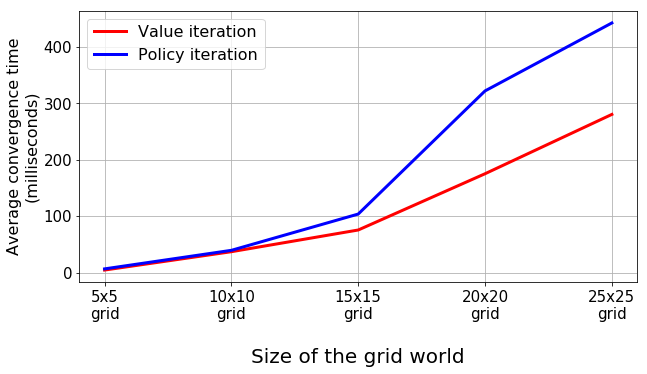

In [59]:
plt.figure (figsize=(10,5))
plt.plot([str(i)+'x'+str(i)+'\ngrid' for i in range(5,26,5)],vi_time,color='red',lw=3)
plt.plot([str(i)+'x'+str(i)+'\ngrid' for i in range(5,26,5)],pi_time,color='blue',lw=3)
plt.legend(["Value iteration","Policy iteration"],fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("\nSize of the grid world",fontsize=20)
plt.ylabel("Average convergence time\n(milliseconds)",fontsize=16)
plt.grid(True)
plt.show()

### Demonstrating the variability of policy iteration as compared to value iteration

In [60]:
vi_iter=[]
pi_iter=[]
for i in range(100):
    _,vi = value_iteration(large_gridworld,0.01)
    _,pi = policy_iteration(large_gridworld)
    vi_iter.append(vi)
    pi_iter.append(pi)

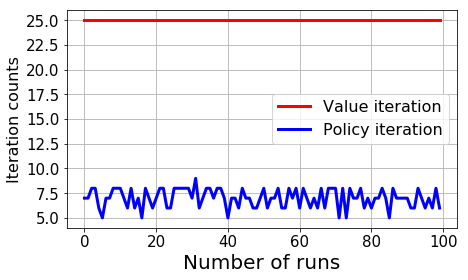

In [61]:
plt.figure (figsize=(7,4))
plt.plot(vi_iter,color='red',lw=3)
plt.plot(pi_iter,color='blue',lw=3)
plt.legend(["Value iteration","Policy iteration"],fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Number of runs",fontsize=20)
plt.ylabel("Iteration counts",fontsize=16)
plt.grid(True)
plt.show()

In [62]:
vi_iter=[]
pi_iter=[]
for i in range(100):
    terminal_rewards = [random.uniform(2,4),-random.uniform(2,4),-random.uniform(4,6)]
    large_grid = gen_mdp(nrows=10,ncols=10,terminals=[(6, 3), (5, 2),(4,4)],
                         main_reward=-random.uniform(0,1),terminal_rewards=terminal_rewards,
                         block_coords=[(1,1),(2,3),(7,5),(8,2)])
    large_gridworld = GridMDP(large_grid,terminals=[(6, 3), (5, 2),(4,4)])
    
    _,vi = value_iteration(large_gridworld,0.01)
    _,pi = policy_iteration(large_gridworld)
    
    vi_iter.append(vi)
    pi_iter.append(pi)

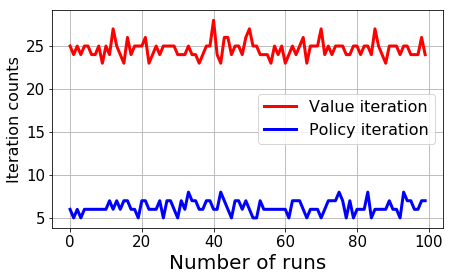

In [63]:
plt.figure (figsize=(7,4))
plt.plot(vi_iter,color='red',lw=3)
plt.plot(pi_iter,color='blue',lw=3)
plt.legend(["Value iteration","Policy iteration"],fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Number of runs",fontsize=20)
plt.ylabel("Iteration counts",fontsize=16)
plt.grid(True)
plt.show()

## Q-learning

### Q-learning class

In [135]:
class QLearningAgent:
    """ An exploratory Q-learning agent. It avoids having to learn the transition
        model because the Q-value of a state can be related directly to those of
        its neighbors.
    """
    def __init__(self, mdp, Ne, Rplus, alpha=None):

        self.gamma = mdp.gamma
        self.terminals = mdp.terminals
        self.all_act = mdp.actlist
        self.Ne = Ne  # iteration limit in exploration function
        self.Rplus = Rplus  # large value to assign before iteration limit
        self.Q = defaultdict(float)
        self.Nsa = defaultdict(float)
        self.s = None
        self.a = None
        self.r = None

        if alpha:
            self.alpha = alpha
        else:
            self.alpha = lambda n: 1./(1+n)

    def f(self, u, n):
        """ Exploration function. Returns fixed Rplus until
        agent has visited state, action a Ne number of times."""
        if n < self.Ne:
            return self.Rplus
        else:
            return u

    def actions_in_state(self, state):
        """ Return actions possible in given state.
            Useful for max and argmax. """
        if state in self.terminals:
            return [None]
        else:
            return self.all_act

    def __call__(self, percept):
        s1, r1 = self.update_state(percept)
        Q, Nsa, s, a, r = self.Q, self.Nsa, self.s, self.a, self.r
        alpha, gamma, terminals = self.alpha, self.gamma, self.terminals,
        actions_in_state = self.actions_in_state

        if s in terminals:
            Q[s, None] = r1
        if s is not None:
            Nsa[s, a] += 1
            Q[s, a] += alpha(Nsa[s, a]) * (r + gamma * max(Q[s1, a1]
                                           for a1 in actions_in_state(s1)) - Q[s, a])
        if s in terminals:
            self.s = self.a = self.r = None
        else:
            self.s, self.r = s1, r1
            self.a = max(actions_in_state(s1), key=lambda a1: self.f(Q[s1, a1], Nsa[s1, a1]))
        return self.a

    def update_state(self, percept):
        """To be overridden in most cases. The default case
        assumes the percept to be of type (state, reward)."""
        return percept

### Trial run function

In [136]:
def run_single_trial(agent_program, mdp):
    """Execute trial for given agent_program
    and mdp."""

    def take_single_action(mdp, s, a):
        """
        Select outcome of taking action a
        in state s. Weighted Sampling.
        """
        x = random.uniform(0, 1)
        cumulative_probability = 0.0
        for probability_state in mdp.T(s, a):
            probability, state = probability_state
            cumulative_probability += probability
            if x < cumulative_probability:
                break
        return state

    current_state = mdp.init
    while True:
        current_reward = mdp.R(current_state)
        percept = (current_state, current_reward)
        next_action = agent_program(percept)
        if next_action is None:
            break
        current_state = take_single_action(mdp, current_state, next_action)

### Testing Q-learning

In [137]:
# Define an agent
q_agent = QLearningAgent(grid_1, Ne=10, Rplus=2,alpha=lambda n: 60./(59+n))

#### A single trial run

In [138]:
run_single_trial(q_agent,grid_1)

#### The utility values are close to default rewards

In [139]:
q_agent.Q

defaultdict(float,
            {((0, 0), (-1, 0)): 0.0,
             ((0, 0), (0, -1)): 0.0,
             ((0, 0), (0, 1)): 0.0,
             ((0, 0), (1, 0)): -0.04,
             ((1, 0), (-1, 0)): 0.0,
             ((1, 0), (0, -1)): 0.0,
             ((1, 0), (0, 1)): 0.0,
             ((1, 0), (1, 0)): -0.04,
             ((2, 0), (-1, 0)): 0.0,
             ((2, 0), (0, -1)): 0.0,
             ((2, 0), (0, 1)): 0.0,
             ((2, 0), (1, 0)): -0.04,
             ((3, 0), (-1, 0)): 0.0,
             ((3, 0), (0, -1)): 0.0,
             ((3, 0), (0, 1)): 0.0,
             ((3, 0), (1, 0)): -0.04,
             ((3, 1), None): 0.0})

#### Run for 200 iterations

In [140]:
for i in range(200):
    run_single_trial(q_agent,grid_1)

#### Q-values looking somewhat improved

In [141]:
q_agent.Q

defaultdict(float,
            {((0, 0), (-1, 0)): -0.1508648941545866,
             ((0, 0), (0, -1)): -0.15942619614228645,
             ((0, 0), (0, 1)): 0.18881994028315593,
             ((0, 0), (1, 0)): -0.16681733227192963,
             ((0, 1), (-1, 0)): -0.10230371985980848,
             ((0, 1), (0, -1)): -0.09903276526347243,
             ((0, 1), (0, 1)): 0.2323460339773079,
             ((0, 1), (1, 0)): -0.10330784708249496,
             ((0, 2), (-1, 0)): -0.09812219051602036,
             ((0, 2), (0, -1)): -0.08731898850702297,
             ((0, 2), (0, 1)): -0.08800729785095428,
             ((0, 2), (1, 0)): 0.2795420480914207,
             ((1, 0), (-1, 0)): 0.1106604144525899,
             ((1, 0), (0, -1)): -0.18399600276552172,
             ((1, 0), (0, 1)): -0.18572997655189435,
             ((1, 0), (1, 0)): -0.17978408224669973,
             ((1, 2), (-1, 0)): -0.042084991887391045,
             ((1, 2), (0, -1)): -0.026684448203540993,
             ((1, 2), (

#### Checking how a particular state's utility evolves over iteration

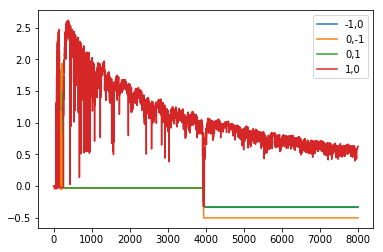

In [142]:
x1=[]
x2=[]
x3=[]
x4=[]

q_agent = QLearningAgent(grid_1, Ne=40, Rplus=1.5,alpha=lambda n: 5000./(4999+n))
for i in range(8000):
    run_single_trial(q_agent,grid_1)
    x1.append(q_agent.Q[((2,2),(-1,0))])
    x2.append(q_agent.Q[((2,2),(0,-1))])
    x3.append(q_agent.Q[((2,2),(0,1))])
    x4.append(q_agent.Q[((2,2),(1,0))])

plt.plot(x1)
plt.plot(x2)
plt.plot(x3)
plt.plot(x4)
plt.legend(['-1,0','0,-1','0,1','1,0'])
plt.show()

### Function to convert the Q Values above into U estimates.

In [143]:
def get_U_from_Q(q_agent):
    U = defaultdict(lambda: -100.) # Large negative value for comparison
    for state_action, value in q_agent.Q.items():
        state, action = state_action
        if U[state] < value:
                    U[state] = value
    return U

In [144]:
get_U_from_Q(q_agent)

defaultdict(<function __main__.get_U_from_Q.<locals>.<lambda>>,
            {(0, 0): 0.3003134549950739,
             (0, 1): 0.3606866544043642,
             (0, 2): 0.44507052375099254,
             (1, 0): 0.12240837870425501,
             (1, 2): 0.539086434725801,
             (2, 0): 0.054135841612979504,
             (2, 1): 0.038400449149821256,
             (2, 2): 0.6276427113103858,
             (3, 0): -0.42464103886879784,
             (3, 1): -0.5427216571679544,
             (3, 2): 0.705470684129441})

### Running Q-learning over a long period and comparing to value iteration method

In [145]:
q_agent = QLearningAgent(grid_1, Ne=25, Rplus=1.5,alpha=lambda n: 10000./(9999+n))
qhistory=[]
for i in range(10000):
    run_single_trial(q_agent,grid_1)
    U=get_U_from_Q(q_agent)
    qhistory.append(U)
print(get_U_from_Q(q_agent))

defaultdict(<function get_U_from_Q.<locals>.<lambda> at 0x000002A6D6CF8E18>, {(0, 0): 0.3949253391464377, (1, 0): 0.3444579424029225, (2, 0): 0.21599987965126283, (3, 0): -0.32043700529600583, (3, 1): 0.9118318007579025, (0, 1): 0.3791678551264691, (0, 2): 0.5624728315423392, (1, 2): 0.7464843097346127, (2, 2): 0.8392698405259547, (3, 2): 0.9067980679662245, (2, 1): 0.06875679152878217})


In [146]:
print(value_iteration(grid_1,epsilon=0.001))

({(0, 1): 0.5574828451603404, (1, 2): 0.7531405483223766, (3, 2): 1.0, (0, 0): 0.464516644753505, (3, 0): 0.22957996193922584, (3, 1): -1.0, (2, 1): 0.5691092225518013, (2, 0): 0.45103488646335127, (2, 2): 0.8553208559957037, (1, 0): 0.38642617706646115, (0, 2): 0.6467925974571826}, 21)


### Function for utility estimate by Q-learning by many iterations

In [147]:
def qlearning_iter(agent_program,mdp,iterations=1000,print_final_utility=True):
    """
    Function for utility estimate by Q-learning by many iterations
    Returns a history object i.e. a list of dictionaries, where utility estimate for each iteration is stored
    
    q_agent = QLearningAgent(grid_1, Ne=25, Rplus=1.5,
                            alpha=lambda n: 10000./(9999+n))
    hist=qlearning_iter(q_agent,grid_1,iterations=10000)
    
    """
    qhistory=[]
    
    for i in range(iterations):
        run_single_trial(agent_program,mdp)
        U=get_U_from_Q(agent_program)
        if len(U)==len(mdp.states):
            qhistory.append(U)
    
    if print_final_utility:
        print(U)
    return qhistory

In [148]:
# Define a Q-learning agent
q_agent = QLearningAgent(grid_1, Ne=25, Rplus=1.5,alpha=lambda n: 10000./(9999+n))
# Run 10000 iterations to get a history
hist=qlearning_iter(q_agent,grid_1,iterations=10000)

defaultdict(<function get_U_from_Q.<locals>.<lambda> at 0x000002A6D6C696A8>, {(0, 0): 0.4900711154747255, (1, 0): 0.2405441517390302, (2, 0): 0.2176153447177856, (3, 0): -0.48331539625394726, (3, 1): -0.381204513862658, (0, 1): 0.6002481824070857, (2, 1): 0.37485218513982377, (0, 2): 0.7022048577156954, (1, 2): 0.7927537919153599, (2, 2): 0.858541903689368, (3, 2): 0.9674055267320101})


### How do the long-term utility estimates with Q-learning compare with value iteration?

In [149]:
def plot_qlearning_vi(hist, vi,plot_n_states=None):
    """
    Compares and plots a Q-learning and value iteration results for the utility estimate of an MDP's states
    hist: A history object from a Q-learning run
    vi: A value iteration estimate for the same MDP
    plot_n_states: Restrict the plotting for n states (randomly chosen)
    """
    utilities={k:[] for k in list(vi[0].keys())}
    for h in hist:
        for state in h.keys():
            utilities[state].append(h[state])
    
    if plot_n_states==None:
        for state in list(vi[0].keys()):
            plt.figure(figsize=(7,4))
            plt.title("Plot of State: {} over Q-learning iterations".format(str(state)),fontsize=16)
            plt.plot(utilities[state])
            plt.hlines(y=vi[0][state],xmin=0,xmax=1.1*len(hist))
            plt.legend(['Q-learning estimates','Value iteration estimate'],fontsize=14)
            plt.xlabel("Iterations",fontsize=14)
            plt.ylabel("Utility of the state",fontsize=14)
            plt.grid(True)
            plt.show()
    else:
        for state in list(vi[0].keys())[:plot_n_states]:
            plt.figure(figsize=(7,4))
            plt.title("Plot of State: {} over Q-learning iterations".format(str(state)),fontsize=16)
            plt.plot(utilities[state])
            plt.hlines(y=vi[0][state],xmin=0,xmax=1.1*len(hist))
            plt.legend(['Q-learning estimates','Value iteration estimate'],fontsize=14)
            plt.xlabel("Iterations",fontsize=14)
            plt.ylabel("Utility of the state",fontsize=14)
            plt.grid(True)
            plt.show()

### Testing the long-term utility learning for the small (default) grid world

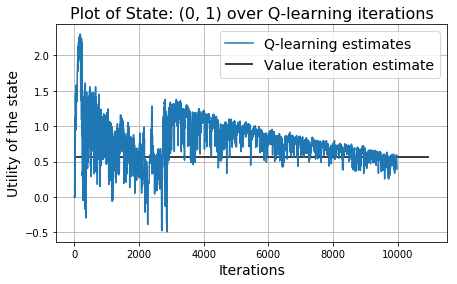

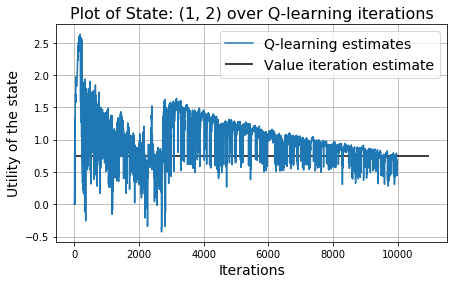

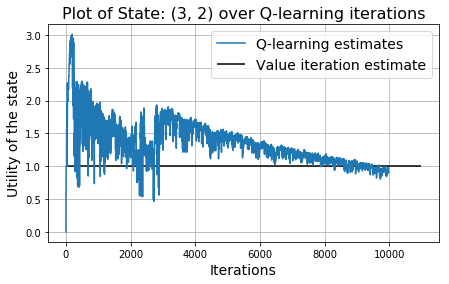

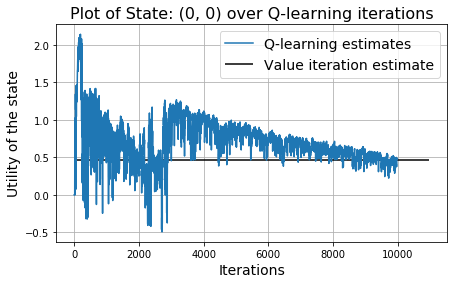

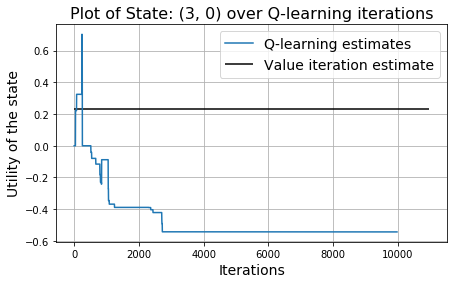

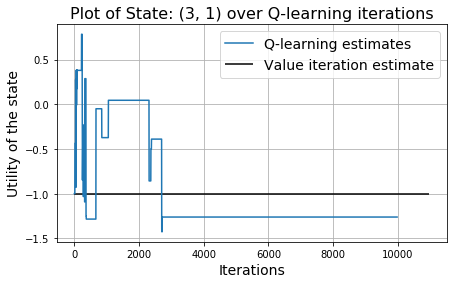

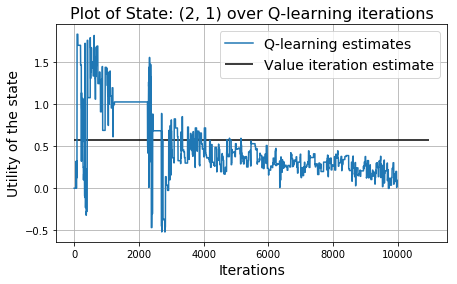

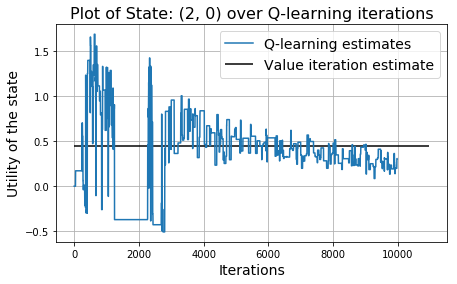

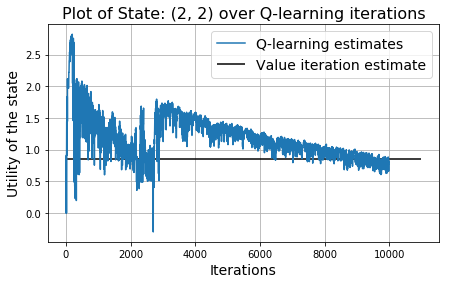

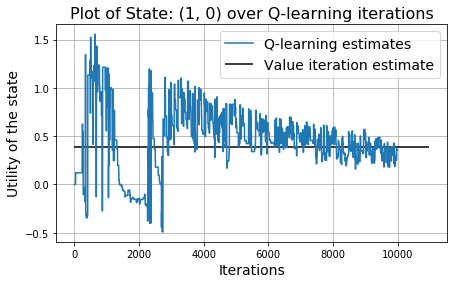

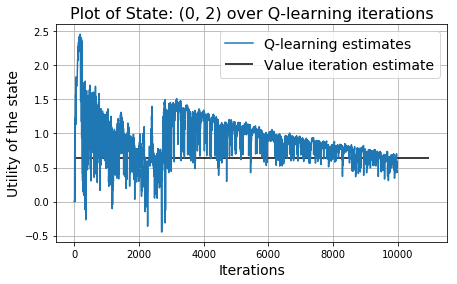

In [150]:
# Define the Q-learning agent
q_agent = QLearningAgent(grid_1, Ne=20, Rplus=2,alpha=lambda n: 10000/(9999+n))
# Obtain the history by running the Q-learning for many iterations
hist=qlearning_iter(q_agent,grid_1,iterations=10000,print_final_utility=False)
# Get a value iteration estimate using the same MDP
vi = value_iteration(grid_1,epsilon=0.001)
# Compare the utility estimates from two methods
plot_qlearning_vi(hist,vi)

### Testing the long-term utility learning for the large grid world

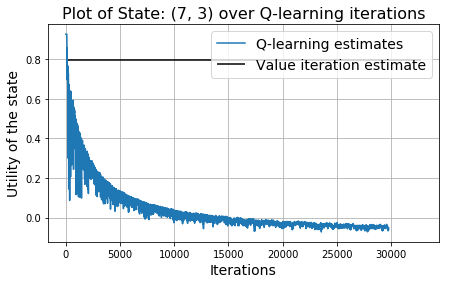

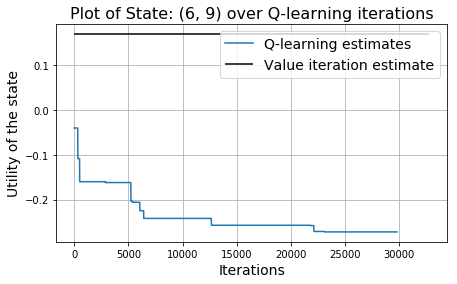

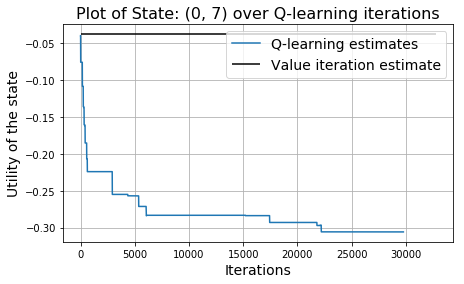

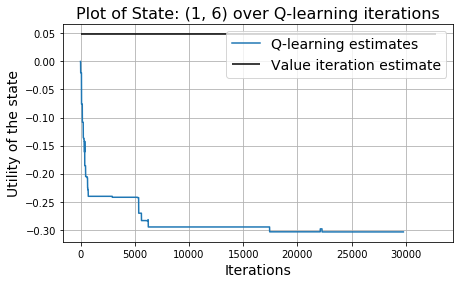

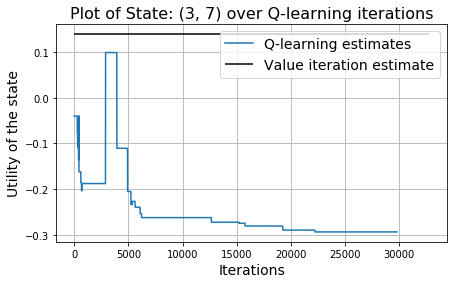

In [161]:
# Define the Q-learning agent
q_agent = QLearningAgent(large_gridworld, Ne=20, Rplus=2,alpha=lambda n: 1000/(999+n))
# Obtain the history by running the Q-learning for many iterations
hist=qlearning_iter(q_agent,large_gridworld,iterations=30000,print_final_utility=False)
# Get a value iteration estimate using the same MDP
vi = value_iteration(large_gridworld,epsilon=0.001)
# Compare the utility estimates from two methods (plot only 5 states)
plot_qlearning_vi(hist,vi,plot_n_states=5)

## Using `pymdptoolbox` Q-learning: A more robust Q-learning algorithm

The [MDP toolbox](https://pymdptoolbox.readthedocs.io/en/latest/index.html) provides classes and functions for the resolution of descrete-time Markov Decision Processes. The list of algorithms that have been implemented includes backwards induction, linear programming, policy iteration, q-learning and value iteration along with several variations.

You can simply install it using,

`pip install pymdptoolbox`

Their Q-learning algorithm uses,
* max 100 visits to each state, 
* a greedy approach of increasing probability for action choice, and 
* decaying learning rate (inverse square root). 

[Read here to know more details](https://pymdptoolbox.readthedocs.io/en/latest/_modules/mdptoolbox/mdp.html#QLearning)

In [166]:
import mdptoolbox
import mdptoolbox.example

### Generate a random MDP with a specific number of states and actions (here 20 and 4 for example)

In [168]:
P, R = mdptoolbox.example.rand(20, 4)

### Value iteration using the generated MDP

In [170]:
vi = mdptoolbox.mdp.ValueIteration(P, R, 0.96,epsilon=0.001)

In [175]:
vi.run()

In [176]:
vi.V

(3.8529969208974837,
 3.624442947893675,
 3.6547417765581227,
 4.0246093074436935,
 3.813761844823124,
 3.7921651698355014,
 3.979435874221074,
 3.9266427021245596,
 3.9732426836938033,
 3.9808749764940545,
 3.7052976577936563,
 3.8497919779520147,
 4.071472368796166,
 4.029670437403848,
 4.092324734926494,
 3.7468884219170158,
 3.7723812889006254,
 4.333175893562366,
 3.8692516570799422,
 4.152081197501264)

### Q-learning with the same MDP

In [177]:
ql = mdptoolbox.mdp.QLearning(P,R,0.96,n_iter=100000)

In [178]:
ql.run()

In [179]:
ql.Q

array([[1.26790319, 1.20111456, 1.35314556, 4.30174583],
       [1.20172124, 1.20220774, 4.21206826, 1.40873712],
       [2.05338455, 2.04121782, 1.88530214, 4.26199016],
       [4.49688472, 2.17487507, 2.58013881, 2.54027993],
       [4.48330274, 1.56274212, 2.01772658, 1.59944445],
       [0.67295533, 4.03086782, 0.77909241, 0.78218475],
       [2.025956  , 1.67834359, 4.42349985, 1.59679818],
       [2.01863292, 4.48742921, 2.20328876, 2.12457993],
       [1.76575621, 1.7346687 , 2.09397596, 4.10540127],
       [4.315829  , 1.71150305, 1.76510607, 1.43910612],
       [0.54861353, 0.59928687, 0.0363933 , 3.36432603],
       [4.11615966, 0.7627823 , 0.57581723, 0.44108385],
       [4.2439175 , 0.5760567 , 0.83643369, 0.8727218 ],
       [0.16422905, 3.48734888, 0.1749688 , 0.23227082],
       [0.79868696, 0.77326146, 0.76877622, 4.61281589],
       [0.8373481 , 4.08986506, 1.16645089, 1.00864003],
       [3.54461758, 1.21658831, 0.82005426, 0.84809806],
       [4.79665135, 1.80648363,

In [180]:
ql.V

(4.3017458280342895,
 4.212068255673687,
 4.261990155217807,
 4.496884723082577,
 4.483302741098784,
 4.030867824741414,
 4.423499851338593,
 4.487429209567494,
 4.1054012707603285,
 4.315829000571206,
 3.364326028278491,
 4.116159662563403,
 4.243917495915591,
 3.487348884896478,
 4.612815893899296,
 4.089865063060668,
 3.5446175847696124,
 4.7966513476870825,
 4.001972219370916,
 4.397949735404336)

### How to asses the impact of number of states and actions on a Q-learning algorithm?

To further understand the impact of number of states and actions on Q-learning, we create random instances of MDP with various number of states and actions (per state). <br>Then, we run value iteration (with error margin 0.001) and Q-learning (10,000 iterations) on them, and compute the **root-mean-square error (RMSE) of their respective prediction of utilities** i.e. we sum over the differences between utility predictions, square them, and take the mean.  

In [247]:
rmse_dict = defaultdict(list)
mat = np.zeros((5,5))
for i in range(5):
    for j in range(5):
        # Create a random MDP
        P, R = mdptoolbox.example.rand((i+1)*20, (j+1)*5)
        # Value iteration
        vi = mdptoolbox.mdp.ValueIteration(P, R, 0.9,epsilon=0.001)
        vi.run()
        # Q-learning
        ql = mdptoolbox.mdp.QLearning(P,R,0.96,n_iter=10000)
        ql.run()
        viv = np.array(vi.V)
        qlv = np.array(ql.V)
        diff = qlv - viv
        diffsq = diff**2
        rmse = np.sqrt(np.mean(diffsq))
        rmse_dict[i].append(rmse)
        mat[i][j]=rmse
        print("{}, {}, {}".format((i+1)*20, (j+1)*5,rmse))
    print("="*80)

20, 5, 0.3413233616483361
20, 10, 2.2598902021109306
20, 15, 4.520675542970938
20, 20, 6.0075845843586295
20, 25, 4.461530118713196
40, 5, 1.0074814928651283
40, 10, 2.7419743345419993
40, 15, 2.1178903886755593
40, 20, 3.601293797441485
40, 25, 4.187977689161319
60, 5, 0.9271964335536792
60, 10, 1.8589253862698378
60, 15, 2.066420005671096
60, 20, 4.028988604485868
60, 25, 3.5087269217355868
80, 5, 0.9078118885897555
80, 10, 1.406263385570601
80, 15, 2.6431847504244335
80, 20, 2.2656847893695513
80, 25, 4.115382711067253
100, 5, 0.8838367456841726
100, 10, 1.3480455835278036
100, 15, 2.3457299143588615
100, 20, 2.744560058904662
100, 25, 2.5167979918418517


In [248]:
mat

array([[0.34132336, 2.2598902 , 4.52067554, 6.00758458, 4.46153012],
       [1.00748149, 2.74197433, 2.11789039, 3.6012938 , 4.18797769],
       [0.92719643, 1.85892539, 2.06642001, 4.0289886 , 3.50872692],
       [0.90781189, 1.40626339, 2.64318475, 2.26568479, 4.11538271],
       [0.88383675, 1.34804558, 2.34572991, 2.74456006, 2.51679799]])

In [249]:
data = pd.DataFrame(mat,index=[(i+1)*20 for i in range(5)],columns=[(j+1)*5 for j in range(5)])

In [250]:
data

,5,10,15,20,25
20,0.341323,2.259890,4.520676,6.007585,4.461530
40,1.007481,2.741974,2.117890,3.601294,4.187978
60,0.927196,1.858925,2.066420,4.028989,3.508727
80,0.907812,1.406263,2.643185,2.265685,4.115383
100,0.883837,1.348046,2.345730,2.744560,2.516798


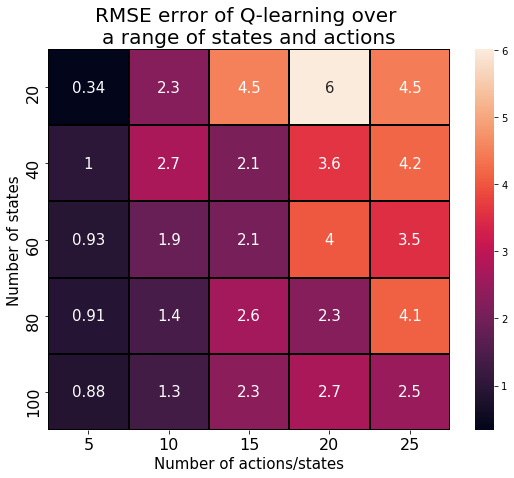

In [254]:
plt.figure(figsize=(9,7))
plt.title("RMSE error of Q-learning over \na range of states and actions",fontsize=20)
heatmap(data,linewidths=1,linecolor='k',annot=True,annot_kws={'fontsize':15})
plt.ylabel("Number of states",fontsize=15)
plt.xlabel("Number of actions/states",fontsize=15)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

From this plot, we conclude that for this grid problem, with proper implementation of Q-learning, large number of states is not necessarily an issue. But the problematic situation is large number of possible actions. In particular, the **performance of Q-learning is worst for MDPs with small number of states but large number of actions/states**. This is due to the random nature of Q-learning initiation for every state visit and the policy of probabilistic walk over all the actions.